## **<span style="color:#023e8a;font-size:200%"><center> [study series] Uplift modeling</center></span>**
## **<center><span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 5px">If you find this notebook useful or interesting, please, support with an upvote :)</span></center>**

# **<a id="Content" style="color:#023e8a;">Table of Content</a>**
* [**<span style="color:#023e8a;">1. Intro</span>**](#Intro)  
* [**<span style="color:#023e8a;">1. First steps</span>**](#First)
* [**<span style="color:#023e8a;">2. Metrics</span>**](#Metrics)  
* [**<span style="color:#023e8a;">3. Meta-Learners</span>**](#Meta)  
    * [**<span style="color:#023e8a;">3.1 S-learner</span>**](#Slearner)  
    * [**<span style="color:#023e8a;">3.2 T-learner</span>**](#Tlearner) 
    * [**<span style="color:#023e8a;">3.3 T-learner dependent models</span>**](#Tlearner_dep) 

## **<span id="Intro" style="color:#023e8a;">Intro</span>**

**<span style="color:#023e8a;">Uplift is a predictive modelling technique for the treatment’s incremental effect estimation at the user level. Every company has a desire to increase its own profits and one of the options is to incentivise customers to buy/to click/to consume or recognize desirable clients. </span>**

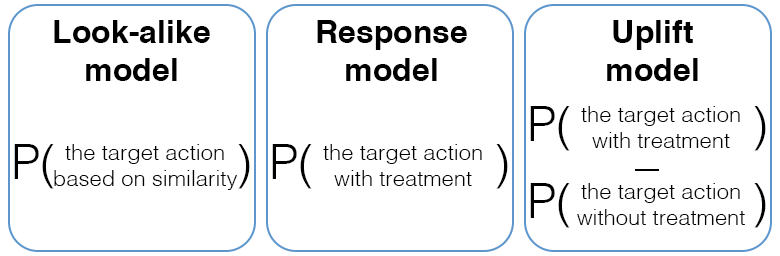

**<span style="color:#023e8a;">1. Look-alike model</span>**

<span style="color:#023e8a;">The base case is to use look-alike modeling. We can understand the behaviour of the client by comparing with its own previous clients with the same characteristics: such as age, education (what we know about them and what they were ready to reveal). This approarch requires our consumer's data with completed actions and some random data of customers who, f.e. don't purchase anything in our store but do so in another one and we have this data. Using this approach and ML we try to find the custumer clients similar to ours in new data, and they will be our main target in promotion. </span>

**<span style="color:#023e8a;">2. Response model</span>**

<span style="color:#023e8a;">Response modeling evaluates the clients that may complete the action after treatment. So we collected data after treatment (communication) and know the positive and negative observations. Some people purchased our product, others don't. Using this data and ML we try to get the probability that the client has completed the needed action after treatment  </span>

**<span style="color:#023e8a;">3. Uplift modeling</span>**

<span style="color:#023e8a;"> Last but not least is the uplift models. Comparing with response models, uplift models evaluate the net effect of the communication (treatment) and try to select solely the customers, who complete the action only after treatment. This group of models estimates the difference in behaviour between groups of customers who have a commutication (treatment) and who have no treatment. We dwell on these models in detail.</span>

<span style="color:#023e8a;">First we denote the action - `Y` (1 - action, 0 - no action) and the treatment `W` (1 - treatment, 0 - no treatment) </span>

<img src="https://growthstage.marketing/wp-content/uploads/2021/04/2x2-Uplift-Modeling-Behavior-Matrix.jpg" width="500" height="500">

**<span style="color:#023e8a;">We may divide clients on 4 groups with the same behaviour: </span>**

🤷 `Will take action` - This group of people completes the action anyway(`Y=1, W=1` and `Y=1, W=0`)

🙋 `Persuadable`  - This group of people completes the action only after treatment(`Y=1, W=1` and `Y=0, W=0`)

🙅 `Do not disturb`  - This group of people performs an action without treatment, but may end it after treatment(`Y=1, W=0` and `Y=0, W=1`)

🤦 `Never will respond`  - This group of people does not care about treatment (`Y=0, W=1` and `Y=0, W=0`)


<span style="color:#023e8a;">`Casual effect` for a customer is the difference between their outcome with treatment and without it:  </span>

$ \tau_i = Y^1_i - Y^0_i $

<span style="color:#023e8a;">`Casual effect` for groups of customers, that is more interesting for the purpose is the difference between expected outcomes of group with treatment and for group without it - `CATE (Conditional Average Treatment Effect)`:  </span>

$ CATE = E[Y^1_i|X_i] - E[Y^0_i|X_i] $

<span style="color:#023e8a;">However we cannot observe these two cases simultaniously, <s>only in different universe</s>. That is why we can only estimate $\widehat{CATE}$ <s>as usual</s>:</span> 

$ \widehat{CATE} (uplift) = E[Y_i|X_i = x, W_i = 1] - E[Y_i|X_i = x, W_i = 0] $, where </span> $ Y^1_i = Y_i = Y^1_i if W_i = 1$ and $Y^0_i$ where $W_i = 0 $

<span style="color:#023e8a;">Note! $W_i$ should be independent from $Y^1_i$ and $Y^0_i$ condidional on $X_i$</span> 


<span style="color:#023e8a;">There are two types of uplift models:</span> 

1. `Meta-Learners` - <span style="color:#023e8a;">Transform problem and use classic ML models</span>

2. `Direct Uplift Models`  - <span style="color:#023e8a;">Alghoritms, that directly predict Uplift.</span>



## **<span id="First" style="color:#023e8a;">1. First steps</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
!pip install scikit-uplift -q
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, TwoModels
import xgboost as xgb

In [ ]:
train = pd.read_csv('../input/megafon-uplift-competition/train (1).csv')

<span style="color:#023e8a;">We see numerous hidden features X_1-X-50, binary treatment (in object format) and binary conversion</span> 

In [ ]:
train.head()

In [ ]:
train.info()

<span style="color:#023e8a;">Features are not standartized or normalized </span> 

In [ ]:
train.describe()

<span style="color:#023e8a;">However, highly likely this features have been cleared. Every feature dist looks like normal. </span> 

In [ ]:
rows, cols = 10, 5
f, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 25))
f.set_facecolor("#fff")
n_feat = 1
for row in tqdm(range(rows)):
    for col in range(cols):
        try:
            sns.kdeplot(x=f'X_{n_feat}', fill=True, alpha=1, linewidth=3, 
                        edgecolor="#264653", data=train, ax=axs[row, col], color='w')
            axs[row, col].patch.set_facecolor("#619b8a")
            axs[row, col].patch.set_alpha(0.8)
            axs[row, col].grid(color="#264653", alpha=1, axis="both")
        except IndexError: # hide last empty graphs
            axs[row, col].set_visible(False)
        n_feat += 1

f.show()

<span style="color:#023e8a;">Just to make sure look at the qq-plot. </span> 

In [ ]:
rows, cols = 10, 5
f, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 25))
f.set_facecolor("#fff")
n_feat = 1
for row in tqdm(range(rows)):
    for col in range(cols):
        try:
#             sns.kdeplot(x=f'X_{n_feat}', fill=True, alpha=1, linewidth=3, 
#                         edgecolor="#264653", data=train, ax=axs[row, col], color='w')
            qqplot(train[f'X_{n_feat}'], ax=axs[row, col], line='q')
            axs[row, col].grid(color="#264653", alpha=1, axis="both")
        except IndexError: # hide last empty graphs
            axs[row, col].set_visible(False)
        n_feat += 1

f.show()

<span style="color:#023e8a;">Next let`s concentrate on modeling. </span> 

## **<span id="First" style="color:#023e8a;">2. Metrics</span>**

<span style="color:#023e8a;">Due to that fact that we have no Uplift before research we cannot use classic metrics for Meta-Learners. However, we need to compare models and understand their accuracy.</span> 

**<span style="color:#023e8a;">1. Uplift@k</span>**
<span style="color:#023e8a;">All what we need is to sort values (DESC) and calculate the difference of mean target (Y) on treatment and control subsets: </span> 
$Uplift@k = mean(Y^{treatment}@k) - mean(Y^{control}@k)$  
$Y@k$ - target on top k%

**<span style="color:#023e8a;">2. Uplift by percentile (decile)</span>**
<span style="color:#023e8a;">The same approarch, but here we calculate the difference in every decile separately</span>   
<span style="color:#023e8a;">Using Uplift by percentile, we may calculate Weighted average uplift:</span> 
Weighted average uplift$ = \frac{N^T_i * uplift_i}{\sum{N^T_i}} $  
$N^T_i$ - size of the treatment subset in i-percentile

**<span style="color:#023e8a;">3. Uplift Curve and AUUC</span>**  
<span style="color:#023e8a;">Uplift curve is a cummulative uplift function dependent on quantity of objects: </span>   
$\text{uplift curve}_i = (\frac{Y^T_t}{N^T_t}-\frac{Y^C_t}{N^C_t}) (N^T_t + N^C_t)$  
$\text{where } t - \text{cummulative quantity of objects}, N - \text{sizes of T and C groups}$  

<span style="color:#023e8a;">AUUC - area under Unplift Curve is an area between random uplift curve and curve from model, normalized by area under ideal Uplift curve</span>  

**<span style="color:#023e8a;">4. Qini Curve and AUQC</span>**  
<span style="color:#023e8a;">Qini curve is a another approach of cummulative function: </span>   
$\text{qini curve}_i = Y^T_t-\frac{Y^C_tN^T_t}{N^C_t}$  

<span style="color:#023e8a;">AUQC or Qini coef - area under Qini Curve is an area between random qini curve and curve from model, normalized by area under ideal Qini curve</span>  


In [ ]:
train.columns

In [ ]:
train['treatment_group'].unique()

In [ ]:
train['treatment_group'] = train['treatment_group'].apply(lambda x: 1 if x=='treatment' else 0)

In [ ]:
from sklearn.model_selection import train_test_split

train = train[:100000]
X = train[[f'X_{i}' for i in range(1, 51)]]
treatment = train['treatment_group']
y = train['conversion']
X_train, X_val, y_train, y_val, treatment_train, treatment_val = train_test_split(X, y, treatment, test_size=0.2)

## **<span id="First" style="color:#023e8a;">3. Meta-Learners</span>**

### **<span id="Slearner" style="color:#023e8a;">3.1 S-Learner</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)

<span style="color:#023e8a;">The main idea of S-learner is to train one model with features, binary treatment (W) and with binary target of action (Y). Then get the prediction for test data with constant W=1 and W=0. The difference is a uplift effect. </span> 

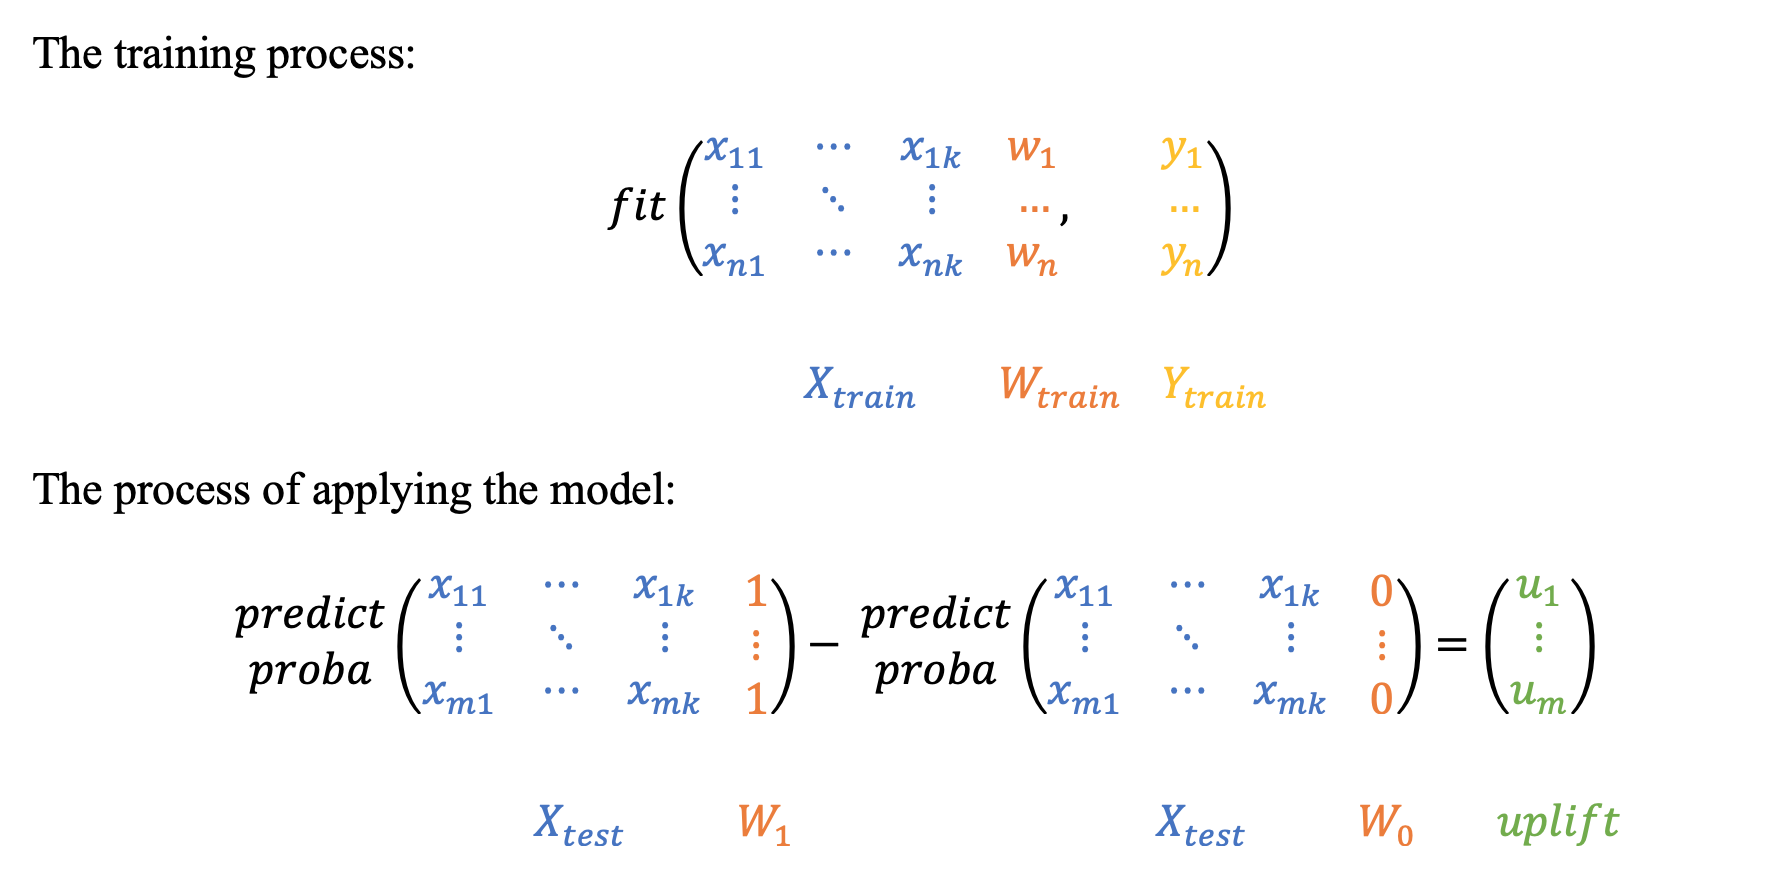

<span style="color:#023e8a;">The good news is that we can use classic ML-classifiers! Let`s do it with xgboost. You may also try it with other classifiers and compare the results.</span> 

In [ ]:
def get_metrics(y_val, uplift, treatment_val):
    #Metrics

    #uplift at top 30%. Strategy by group means sorting control and treatment separately. Overall - together
    upliftk = uplift_at_k(y_true=y_val, uplift=uplift, treatment=treatment_val, strategy='by_group', k=0.3)
    upliftk_all = uplift_at_k(y_true=y_val, uplift=uplift, treatment=treatment_val, strategy='overall', k=0.3)

    qini_coef = qini_auc_score(y_true=y_val, uplift=uplift,
                              treatment=treatment_val)

    #Default strategy - Overall
    # Area Under Uplift Curve
    uplift_auc = uplift_auc_score(y_true=y_val, uplift=uplift,
                                  treatment=treatment_val)
    # Weighted average uplift
    wau = weighted_average_uplift(y_true=y_val, uplift=uplift,
                                  treatment=treatment_val, strategy='by_group')
    wau_all = weighted_average_uplift(y_true=y_val, uplift=uplift,
                                  treatment=treatment_val)

    print(f'uplift at top 30% by group: {upliftk:.2f} by overall: {upliftk_all:.2f}\n',
          f'Weighted average uplift by group: {wau:.2f} by overall: {wau_all:.2f}\n',
          f'AUUC by group: {uplift_auc:.2f}\n',
          f'AUQC by group: {qini_coef:.2f}\n')
    return {'uplift@30': upliftk, 'uplift@30_all': upliftk_all, 'AUQC': qini_coef, 'AUUC': uplift_auc, 
            'WAU': wau, 'WAU_all': wau_all}

In [ ]:
xgb_sm = xgb.XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False)
sm = SoloModel(estimator=xgb_sm)
sm = sm.fit(X_train, y_train, treatment_train, estimator_fit_params={})

uplift_sm = sm.predict(X_val)
res = get_metrics(y_val, uplift_sm, treatment_val)

### **<span id="Tlearner" style="color:#023e8a;">3.2 T-Learner</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)

<span style="color:#023e8a;">The main idea of T-learner is to train two independent models: one based on observations after treatment (T), another one on control rows (C). The uplift effect is the difference between predictions on data from model T and model C. </span> 

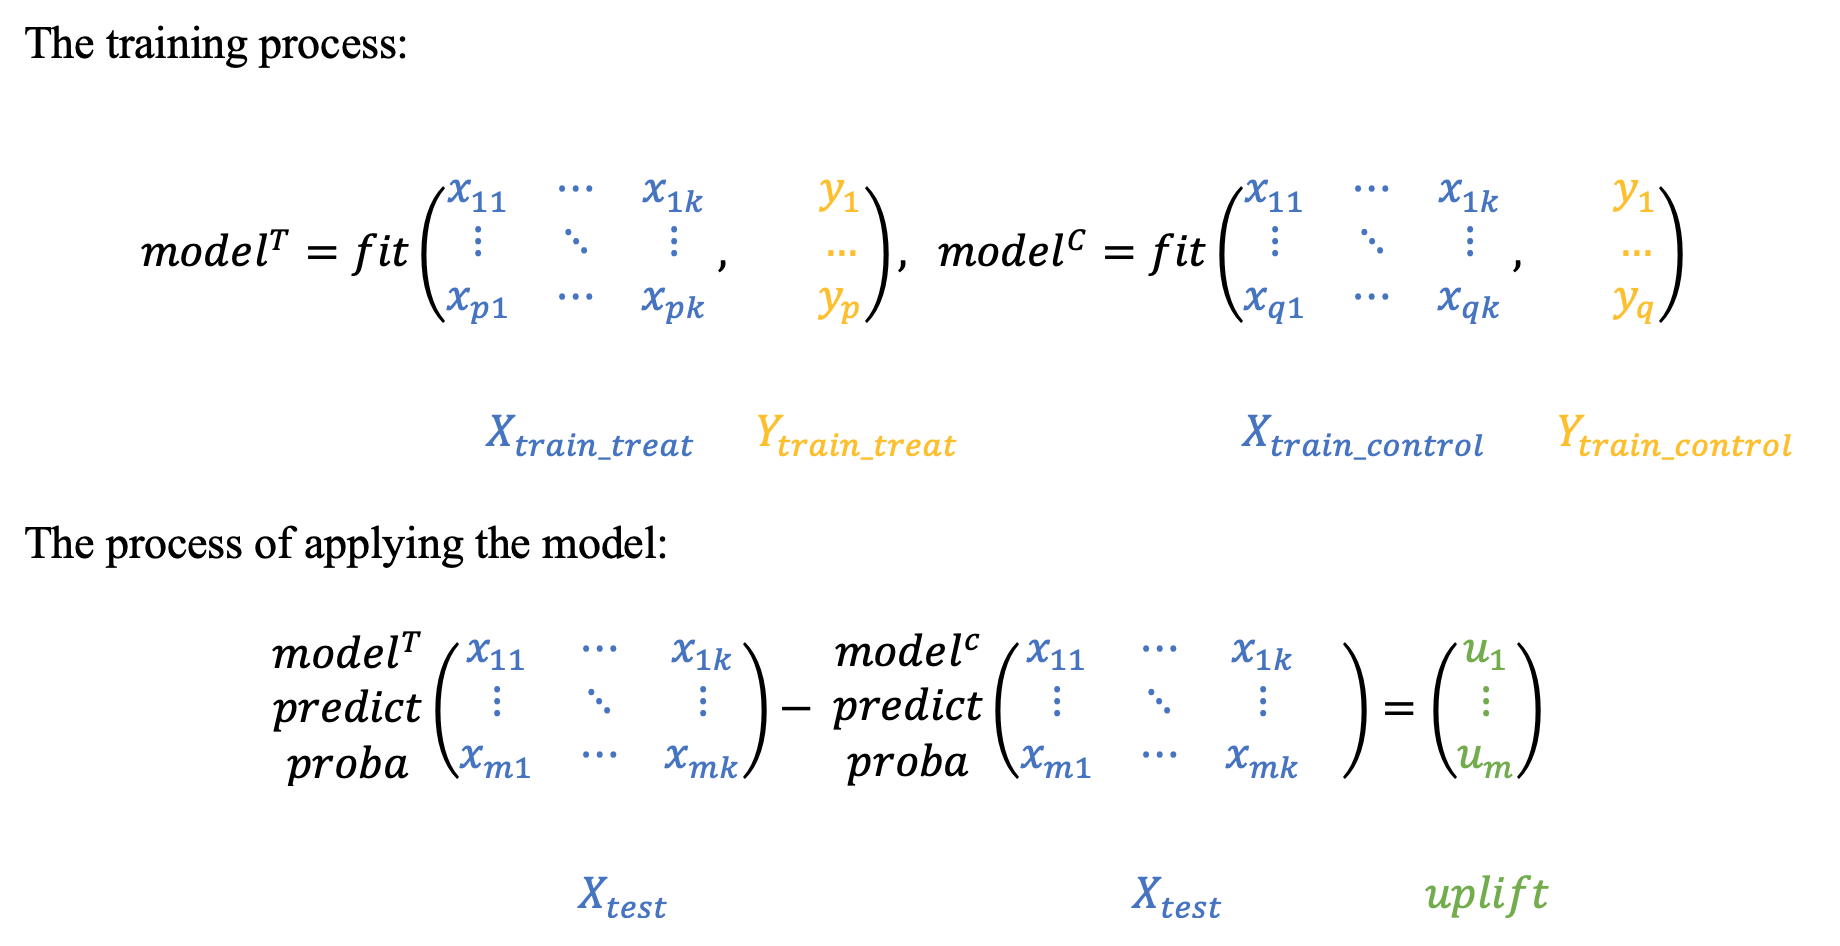

In [ ]:
xgb_T = xgb.XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False)
xgb_C = xgb.XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False)
sm = TwoModels(estimator_trmnt=xgb_T, estimator_ctrl=xgb_C)
sm = sm.fit(X_train, y_train, treatment_train, estimator_trmnt_fit_params={}, estimator_ctrl_fit_params={})

uplift_sm = sm.predict(X_val)
res = get_metrics(y_val, uplift_sm, treatment_val)

<span style="color:#023e8a;">The results are slighly worse, than those of S-learner. </span> 

### **<span id="Tlearner_dep" style="color:#023e8a;">3.3 T-Learner dependent models</span>**

<span style="color:#023e8a;">The main idea of T-learner with dependent models is to train T or C model using predictions (probs) from the opposite model.  
This approach has been adopted from classifier chain method: https://scikit-learn.org/stable/auto_examples/multioutput/plot_classifier_chain_yeast.html</span> 

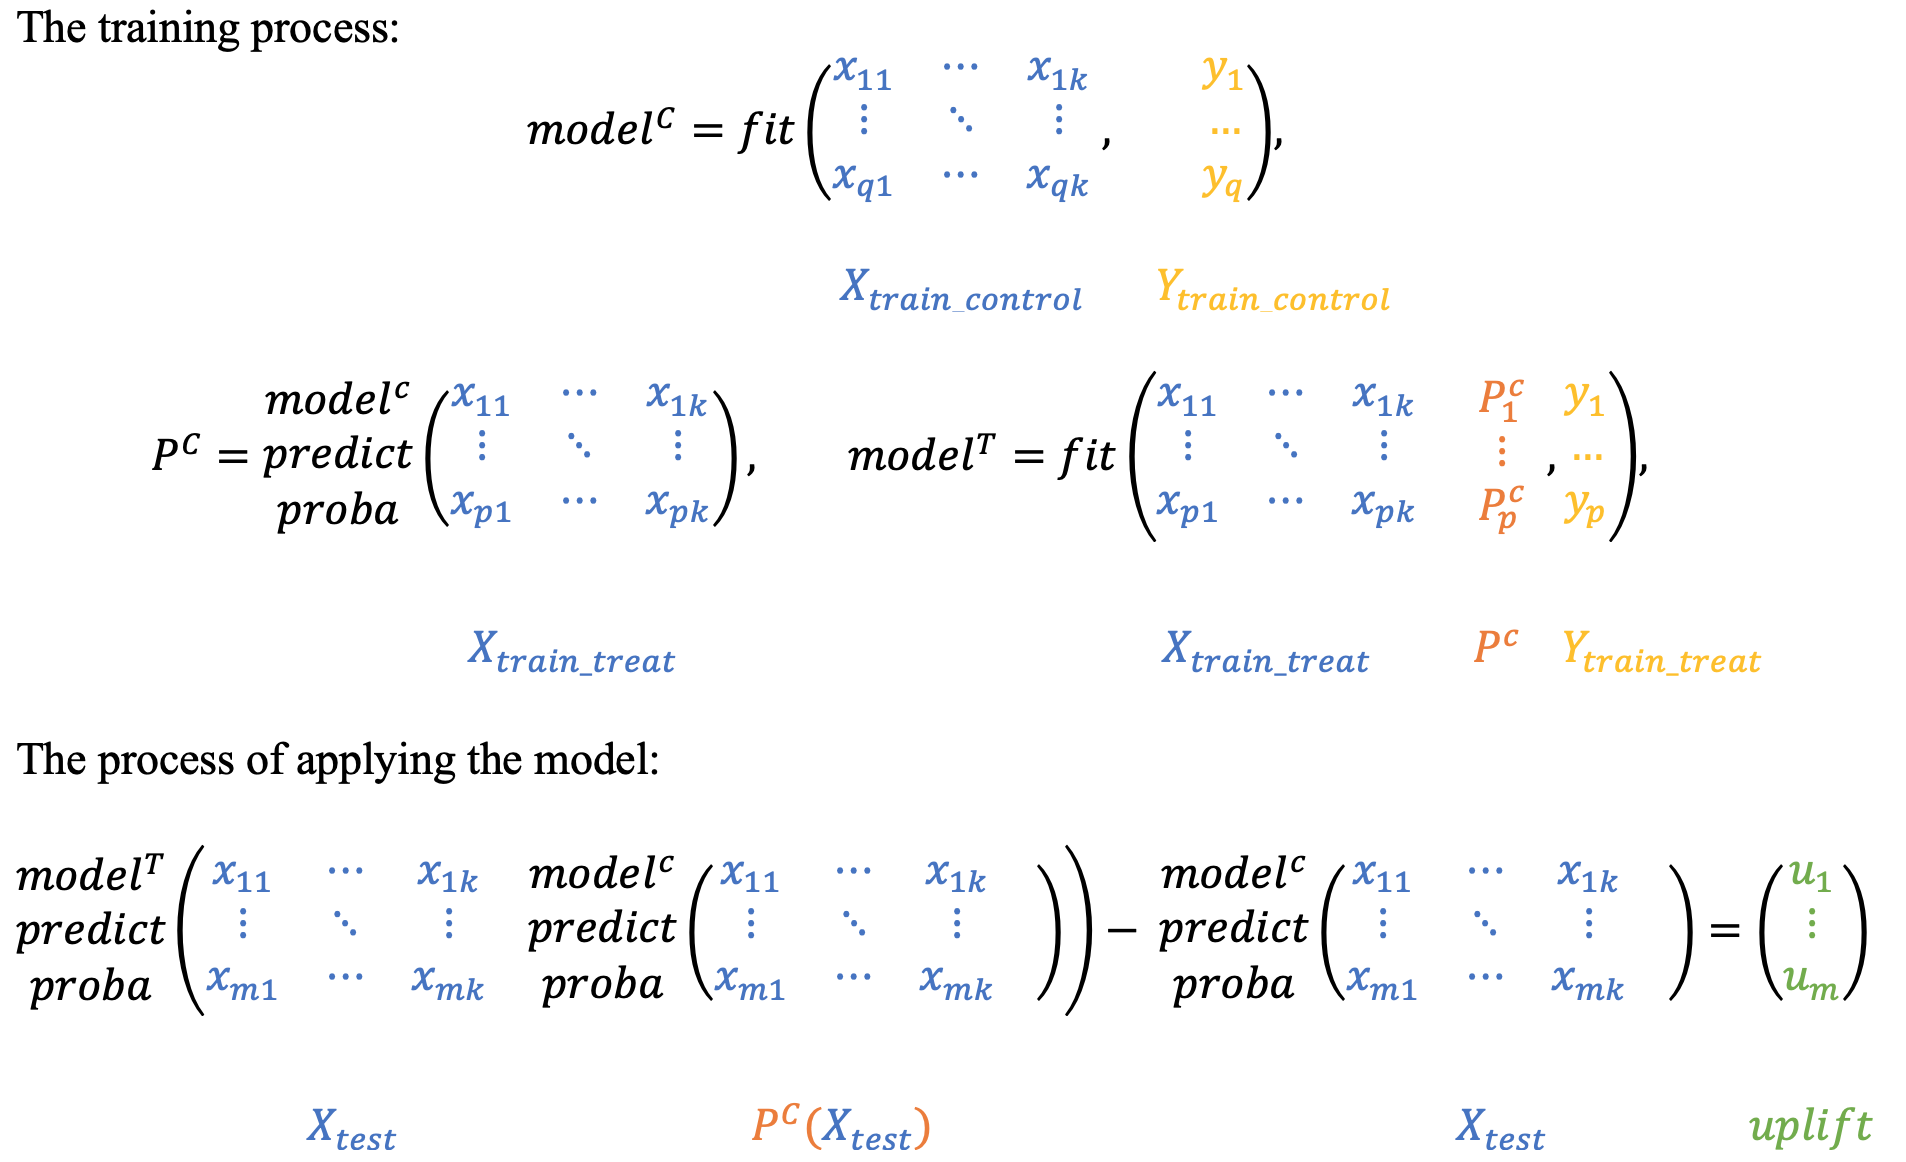

<span style="color:#023e8a;">There are two possible implementions of this approach: based on T-probs in C model and C-probs in T model:</span> 
1. $uplift_i = P^T(x_i, P^C(X)) - P^C(x_i)$  
2. $uplift_i = P^T(x_i) - P^C(x_i, P^T(x_i))$

<span style="color:#023e8a;">First approach:</span> 

In [ ]:
xgb_T = xgb.XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False)
xgb_C = xgb.XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False)
sm = TwoModels(estimator_trmnt=xgb_T, estimator_ctrl=xgb_C, method='ddr_control')
sm = sm.fit(X_train, y_train, treatment_train, estimator_trmnt_fit_params={}, estimator_ctrl_fit_params={})

uplift_sm = sm.predict(X_val)
res = get_metrics(y_val, uplift_sm, treatment_val)

<span style="color:#023e8a;">Second approach:</span> 

In [ ]:
xgb_T = xgb.XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False)
xgb_C = xgb.XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False)
sm = TwoModels(estimator_trmnt=xgb_T, estimator_ctrl=xgb_C, method='ddr_treatment')
sm = sm.fit(X_train, y_train, treatment_train, estimator_trmnt_fit_params={}, estimator_ctrl_fit_params={})

uplift_sm = sm.predict(X_val)
res = get_metrics(y_val, uplift_sm, treatment_val)

## **<center><span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 5px; font-size: 15pt">In a process....</span></center>**

## **<center><span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 5px; font-size: 15pt">Thanks for reading! If you find this notebook useful or interesting, please, support with an upvote :)</span></center>**

References:
https://www.uplift-modeling.com/en/latest/  
https://habr.com/ru/company/ru_mts/blog/485980/